<a href="https://colab.research.google.com/github/gouthamans14/deeplearning-tesnorflow/blob/main/TransferLearning/TransferLearning_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  Transfer Learning with TensorFlow

There are two main benefits:

Can leverage an existing NN architectrure proven to work on problem similar to ours<br>
Can leverage a working NN architecture which has already learnt some pattern on similar data to our own, then we can adapt those patterns to our own data

In [5]:
##Checking GPU
!nvidia-smi

Thu Jun 29 09:45:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1) Downloading and Becoming one with Data

In [6]:
import zipfile

#download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-06-29 09:45:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 142.251.175.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  22.5MB/s    in 8.3s    

2023-06-29 09:45:49 (19.4 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [7]:
import os
import pathlib

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 0 images in 10_food_classes_10_percent
There are 10 folders and 0 images in 10_food_classes_10_percent/test
There are 0 folders and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 folders and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 folders and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 folders and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 folders and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 folders and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 folders and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 folders and 250 images in 10_food_classes_10_percent/test/steak
There are 0 folders and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 folders and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 10 folders and 0 images in 10_food_classes_10_percent/train


### 2) Creating Data Loader (Preprocessing the Data)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir  = "10_food_classes_10_percent/test/"

In [9]:
train_datagen =ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [10]:
print("Training Images: ")
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                              target_size= IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE,
                                               class_mode="categorical")

print("Testing Images: ")
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                              target_size=IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE,
                                               class_mode="categorical")


Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


### Setting Up Callbacks

-- Things to run while our model trains.

Callbacks are extra functionality one can add to models to be performed during or after training

Popular callbacks:

* Tracking experiments with **TensorBoard Callback**.
* Model Checkpoint with **Model Checkpoint** callback
* Stopping a model from training (before it trains too lonf and overfits)
with the **Early Stopping callback**

### Tensorboard Callbacks:

Tracks the model performaces. Easy to refer.

#### Ceating a Tensorboard callback function

In [11]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

    log_dir = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    print(f"Saving tensorflow log_dirs to {log_dir}")
    return tensorboard_callback


#### Creating models using tensorflow hub

In [12]:
m = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",trainable=False),  # Can be True, see below.
tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, expect_img_size, expect_img_size, 3]) # Batch input shape.


SyntaxError: ignored

#### Model Comparison

lets compare resnet and imagenet

##### TensorFlow Hub

* A place to find a plethora of pre-trained machine learning models (ready to be applied and fine-tuned for our own problems)

In [17]:
resnet_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
effecientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

#### Create model helper function

In [19]:
def create_model(model_url, num_classes=10):

    """
    Takes a tensorflow hub url and creates a keras sequential model with it.

    Args:
    model_url (str): A tensorflow hub creates extraction url.

    num_classes(int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and
    Dense output layer with num_classes output neurons.

    """
    # Download a pretrained model and save it as Keras layer.

    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name= "feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,)) #Freeze already learned patterns
    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dense(num_classes, activation="softmax",name="output_layer")

    ])

    return model




In [20]:
IMAGE_SHAPE +(3,)

(224, 224, 3)

### Creating and Testing Resnet Feature Extraction Model:

In [21]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
resnet_history = resnet_model.fit(train_data,epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")])

Saving tensorflow log_dirs to tensorflow_hub/resnet50V2/20230629-094629
Epoch 1/5
24/24 [==============================] - 34s 901ms/step - loss: 1.8604 - accuracy: 0.3947 - val_loss: 1.1840 - val_accuracy: 0.6364
Epoch 2/5
24/24 [==============================] - 18s 767ms/step - loss: 0.9178 - accuracy: 0.7133 - val_loss: 0.8381 - val_accuracy: 0.7396
Epoch 3/5
24/24 [==============================] - 19s 806ms/step - loss: 0.6201 - accuracy: 0.8227 - val_loss: 0.7498 - val_accuracy: 0.7604
Epoch 4/5
24/24 [==============================] - 18s 754ms/step - loss: 0.4800 - accuracy: 0.8800 - val_loss: 0.7018 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 19s 822ms/step - loss: 0.3881 - accuracy: 0.9107 - val_loss: 0.6812 - val_accuracy: 0.7772


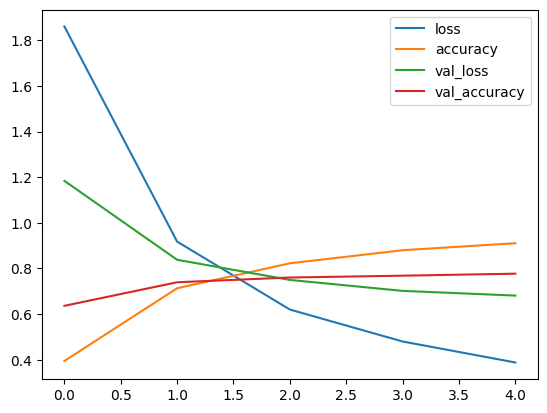

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(resnet_history.history).plot()
plt.show()

* Transfer learning feature extractor model out-performed all the previous model we haeve built.

* We have used only 10 percent of the data

<Axes: >

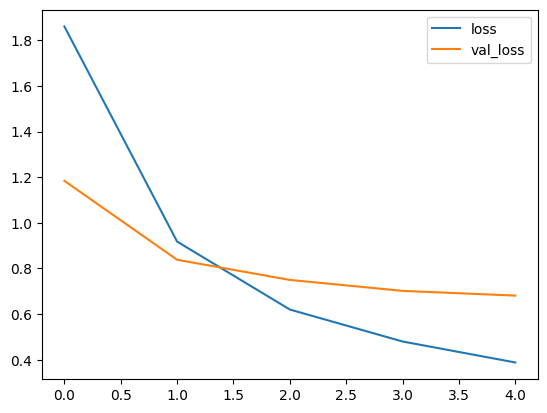

In [27]:
history_df = pd.DataFrame(resnet_history.history)
history_df[["loss","val_loss"]].plot(kind="line")

#### Plot Curver helper function

In [28]:
def plot_loss_curve(history):
    history_df = pd.DataFrame(history.history)
    epoch = range(0,len(history_df["loss"]))
    plt.figure(figsize=(12,6))
    #plt.title("Resnet Curves")
    plt.subplot(1,2,1)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot( epoch, history_df["loss"],label="Train loss")
    plt.plot(epoch, history_df["val_loss"],label="Val Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.subplot(1,2,2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, history_df["accuracy"], label="Train Accuracy")
    plt.plot(epoch, history_df["val_accuracy"], label="Val Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    #history_df[["loss","val_loss"]].plot(kind="line")
    #history_df[["accuracy","val_accuracy"]].plot(kind="line")
    plt.show()



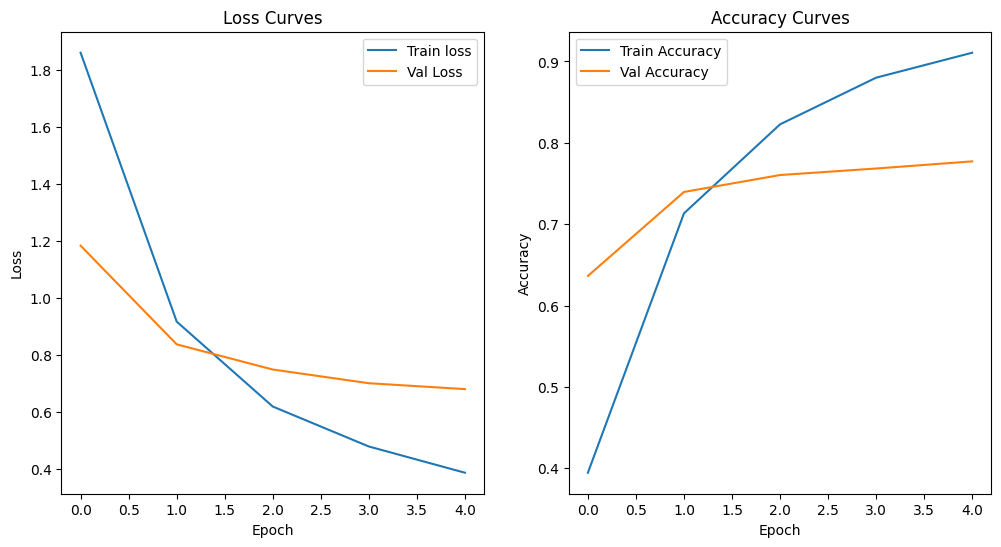

In [29]:
plot_loss_curve(resnet_history)

### Creating and Testing EfficientNetB0 Tensorflow Hub Feature Extraction Model

In [30]:

efficientnet_model = create_model(effecientnet_url, num_classes=train_data.num_classes)


In [31]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [32]:
efficientnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [33]:
effecientnet_history = efficientnet_model.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data = test_data,
                       validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnetB0")] )

Saving tensorflow log_dirs to tensorflow_hub/efficientnetB0/20230629-094841
Epoch 1/5
24/24 [==============================] - 31s 821ms/step - loss: 1.8208 - accuracy: 0.4467 - val_loss: 1.2709 - val_accuracy: 0.7292
Epoch 2/5
24/24 [==============================] - 19s 823ms/step - loss: 1.0363 - accuracy: 0.7827 - val_loss: 0.8615 - val_accuracy: 0.8276
Epoch 3/5
24/24 [==============================] - 18s 761ms/step - loss: 0.7483 - accuracy: 0.8453 - val_loss: 0.6920 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 18s 782ms/step - loss: 0.6000 - accuracy: 0.8640 - val_loss: 0.6097 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 18s 775ms/step - loss: 0.5064 - accuracy: 0.8880 - val_loss: 0.5548 - val_accuracy: 0.8660


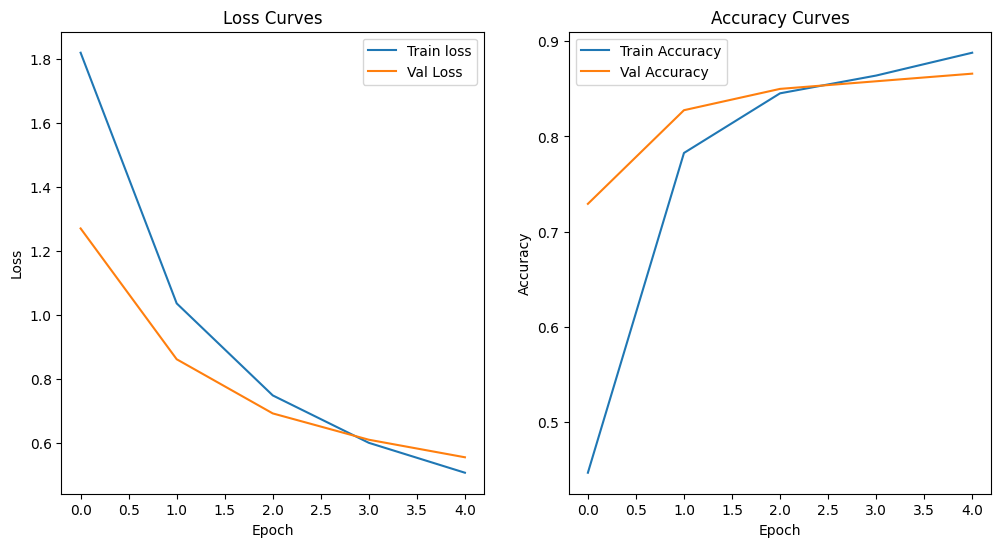

In [34]:
plot_loss_curve(effecientnet_history)

### Different Types of Transfer Learning

1) **"As Is Transfer Learning"** - Using an existing model with no changes what so ever (e.g using Imagenet model on 1000 Imagenet classe, none of our own) </br>

2) **"Feature Extraction Transfer learning"**  - Use the pre-learned patterns of an existing model (Eg Efficient net b0 trained on imagenet)
and adjust the output layers for our own problem
(ie 1000 classes to 10 classes of food)</br>

3) **"Fine Tuning Transfer learning"** - Use the pre-learned patterns of an existing model and fine-tune many or all of the underlying layers including output layers

In [35]:
len(efficientnet_model.layers[0].weights) # number of layers in the effecient net model

309

In [ ]:
efficientnet_model

### Comparing our Model using Tensorboard

**Note** : When you upload things to Tensorboard.dev the experiments are public. So if you're running private experiments
do not upload to tensorboard.dev

In [36]:
# Upload TensorBoard records
!tensorboard dev upload \
--logdir ./tensorflow_hub/ \
--name "EffecientNetB0 vs ResNet50V2" \
--description "Comparing two different TF hub feature extraction model architectures using 10% of the training data" \
--one_shot

2023-06-29 09:54:03.609218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   DWT-PHW-XDQ



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


2023-06-29 07:23:30.724420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   ZHF-YWR-DRW



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

Our Tensorboard experiment are uploaded publicly here : https://tensorboard.dev/experiment/zWVxKxxVQBe7J13WnZMkDw/

In [37]:
! tensorboard dev list

2023-06-29 09:55:51.259414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/H5ElTM1YRgOQ5TZIgf7qyA/
	Name                 EffecientNetB0 vs ResNet50V2
	Description          Comparing two different TF hub feature extraction model architectures using 10% of the training data
	Id                   H5ElTM1YRgOQ5TZIgf7qyA
	Created              2023-06-29 09:54:34 (1 minute ago)
	Updated              2023-06-29 09:54:38 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5934984
https://tensorboard.dev/experiment/zWVxKxxVQBe7J13WnZMkDw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   zWVxKxxVQBe7J13WnZMkDw
	Created              2023-06-29 07:25:04 (2 hours ago)
	Updated              2